In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
## clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16525, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 16525 (delta 0), reused 2 (delta 0), pack-reused 16522
Receiving objects: 100% (16525/16525), 15.00 MiB | 24.19 MiB/s, done.
Resolving deltas: 100% (11359/11359), done.
/kaggle/working/yolov5


In [3]:
## installing all the necessary dependencies
!pip install -qr requirements.txt
import torch

from IPython.display import Image, clear_output

print("Setup completed, Using torch %s %s " % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else "CPU"))

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
Setup completed, Using torch 2.1.2 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16276MB, multi_processor_count=56) 


In [4]:
%cd /kaggle/working/

/kaggle/working


In [5]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "sign_language_detection"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "sign_language_detection.zip", "wb") as f:
        request = requests.get("https://github.com/TapanKheni10/DataSets/raw/main/Sign_Language_Detection.v3i.yolov5pytorch.zip")
        print("Downloading sign language data....")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "sign_language_detection.zip", "r") as zip_ref:
        print("Unzipping sign language data....") 
        zip_ref.extractall(image_path)

Did not find data/sign_language_detection directory, creating one...
Unzipping sign language data....


In [6]:
import os
os.remove(data_path / "sign_language_detection.zip")

In [7]:
%cd /kaggle/working/data/sign_language_detection/Sign_Language_Detection.v3i.yolov5pytorch
%cat data.yaml

/kaggle/working/data/sign_language_detection/Sign_Language_Detection.v3i.yolov5pytorch
train: ../data/sign_language_detection/Sign_Language_Detection.v3i.yolov5pytorch/train/images
val: ../data/sign_language_detection/Sign_Language_Detection.v3i.yolov5pytorch/valid/images
test: ../data/sign_language_detection/Sign_Language_Detection.v3i.yolov5pytorch/test/images

nc: 6
names: ['Hello', 'I Love You', 'No', 'Please', 'Thanks', 'Yes']

roboflow:
  workspace: mysterycv
  project: sign_language_detection-n9uur
  version: 3
  license: MIT
  url: https://universe.roboflow.com/mysterycv/sign_language_detection-n9uur/dataset/3



Model Configuration

In [8]:
import yaml
with open("data.yaml", "r") as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])   
    
num_classes

'6'

In [9]:
## This the default configuration of the model that we're gonna use
%cat /kaggle/working/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 

In [10]:
## customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, "w") as f:
        f.write(cell.format(**globals()))

In [11]:
%%writetemplate /kaggle/working/yolov5/models/custom_yolov5s.yaml

# Parameters
nc: {num_classes} # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]
     

Training Custom YOLOv5 Detector

In [13]:
%%time
%cd /kaggle/working/yolov5
%pwd

/kaggle/working/yolov5
CPU times: user 1.54 ms, sys: 147 µs, total: 1.68 ms
Wall time: 1.32 ms


'/kaggle/working/yolov5'

In [15]:
!python train.py --img 416 --batch 16 --epochs 250 --data '../data/sign_language_detection/Sign_Language_Detection.v3i.yolov5pytorch/data.yaml' --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results --cache

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-04-09 10:57:08.065931: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 10:57:08.065986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 10:57:08.067453: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train:

Evaluate the Performance of Custom YOLOv5 Detector

In [18]:
# %load_ext tensorboard
# %tensorboard --logdir runs

In [19]:
!nvidia-smi

Tue Apr  9 11:11:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0              27W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

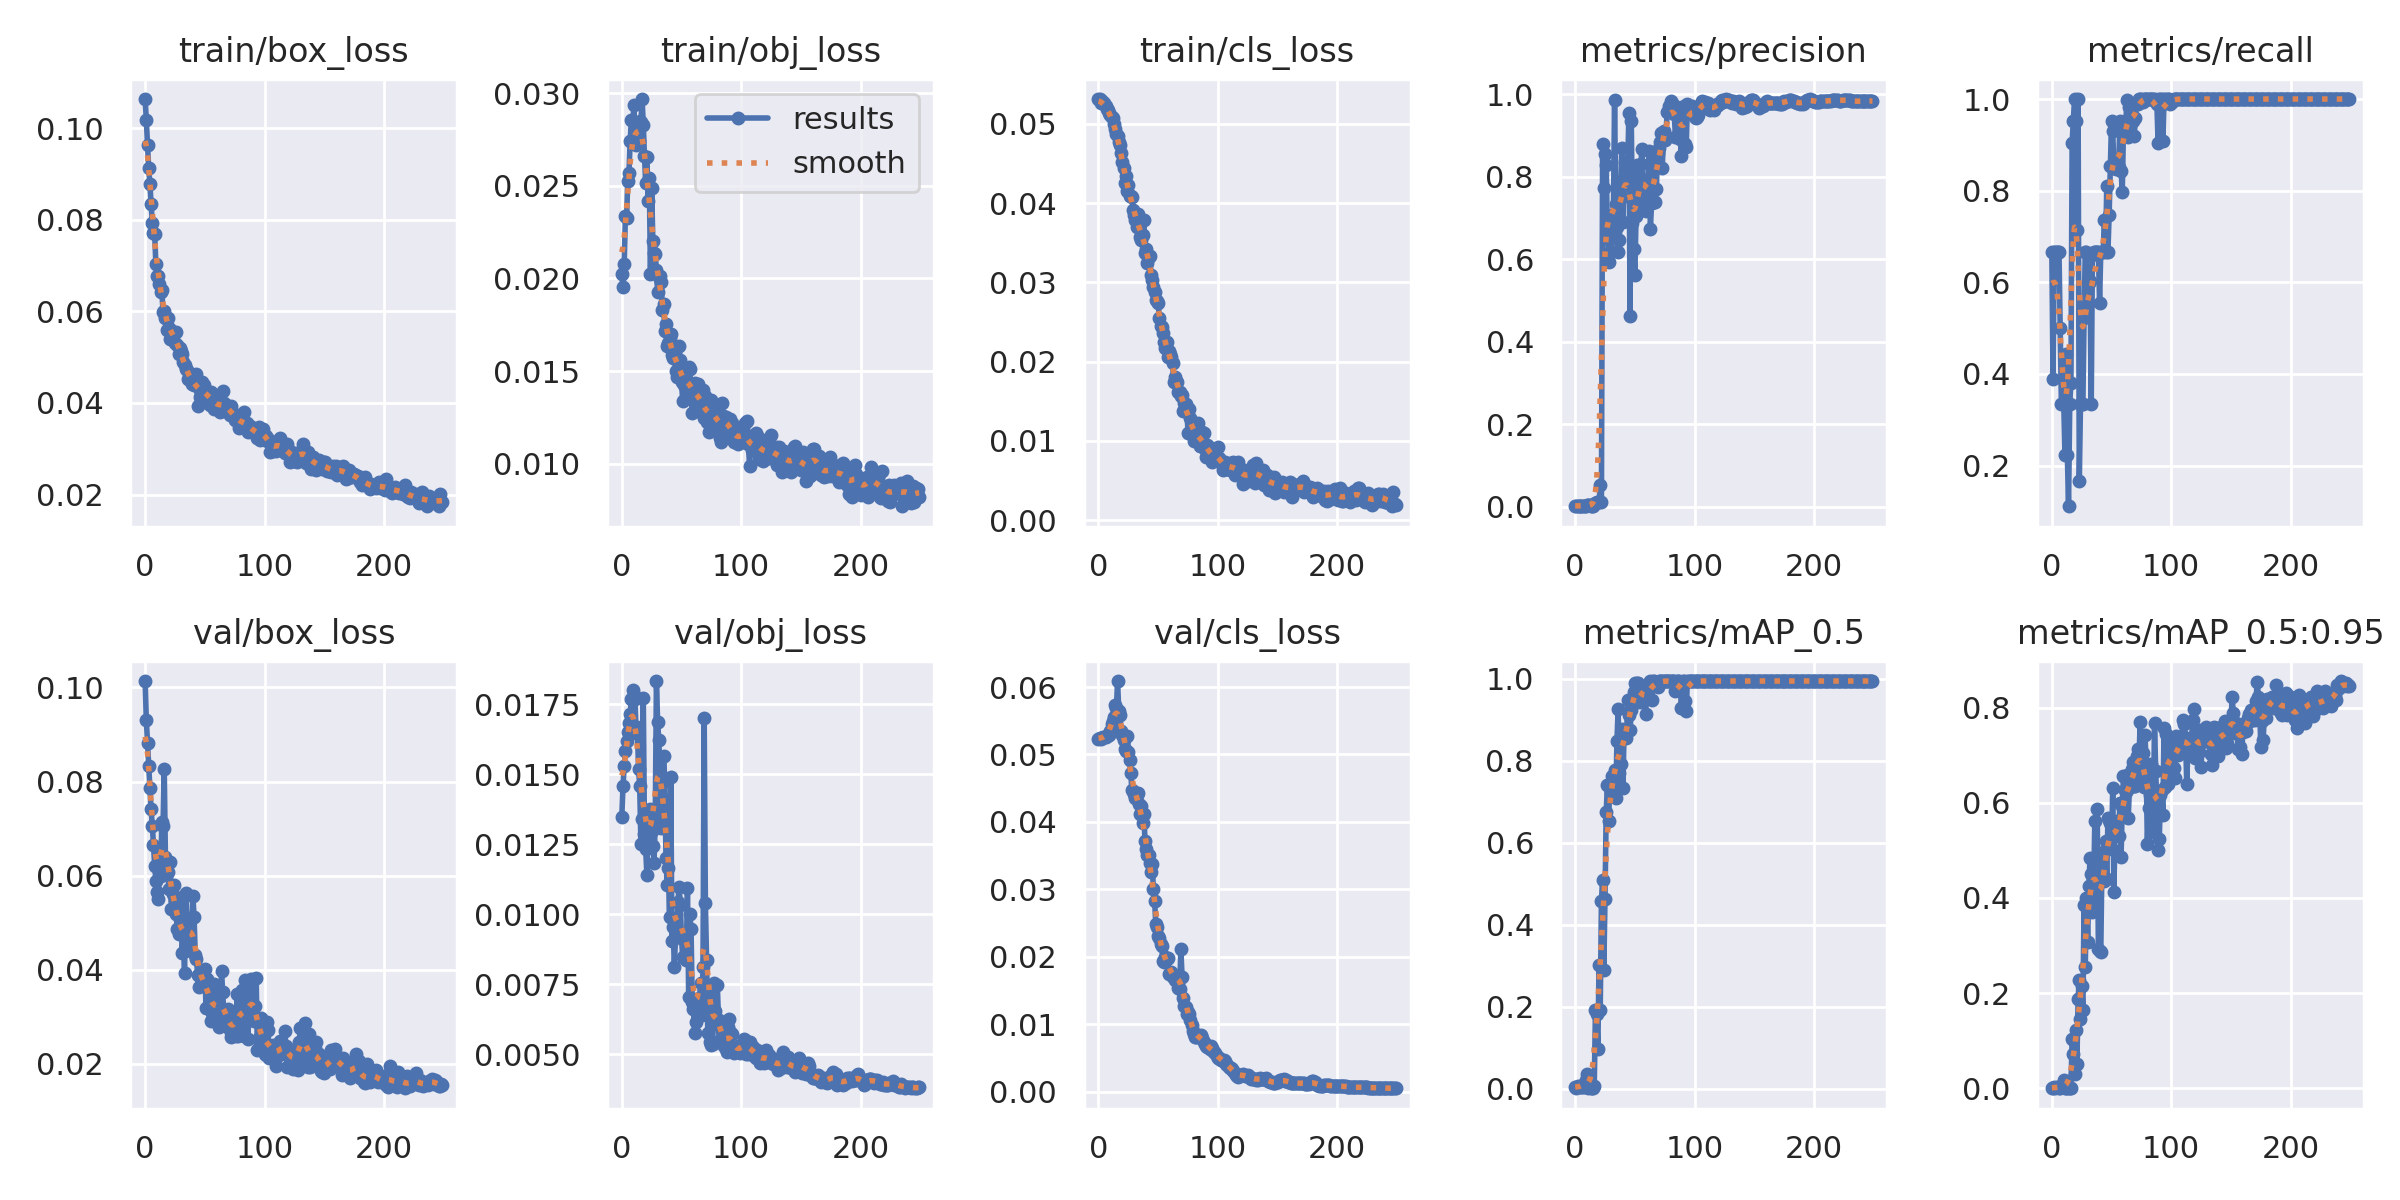

In [21]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/kaggle/working/yolov5/runs/train/yolov5s_results/results.png', width=5000)

GROUND TRUTH TRAINING DATA:


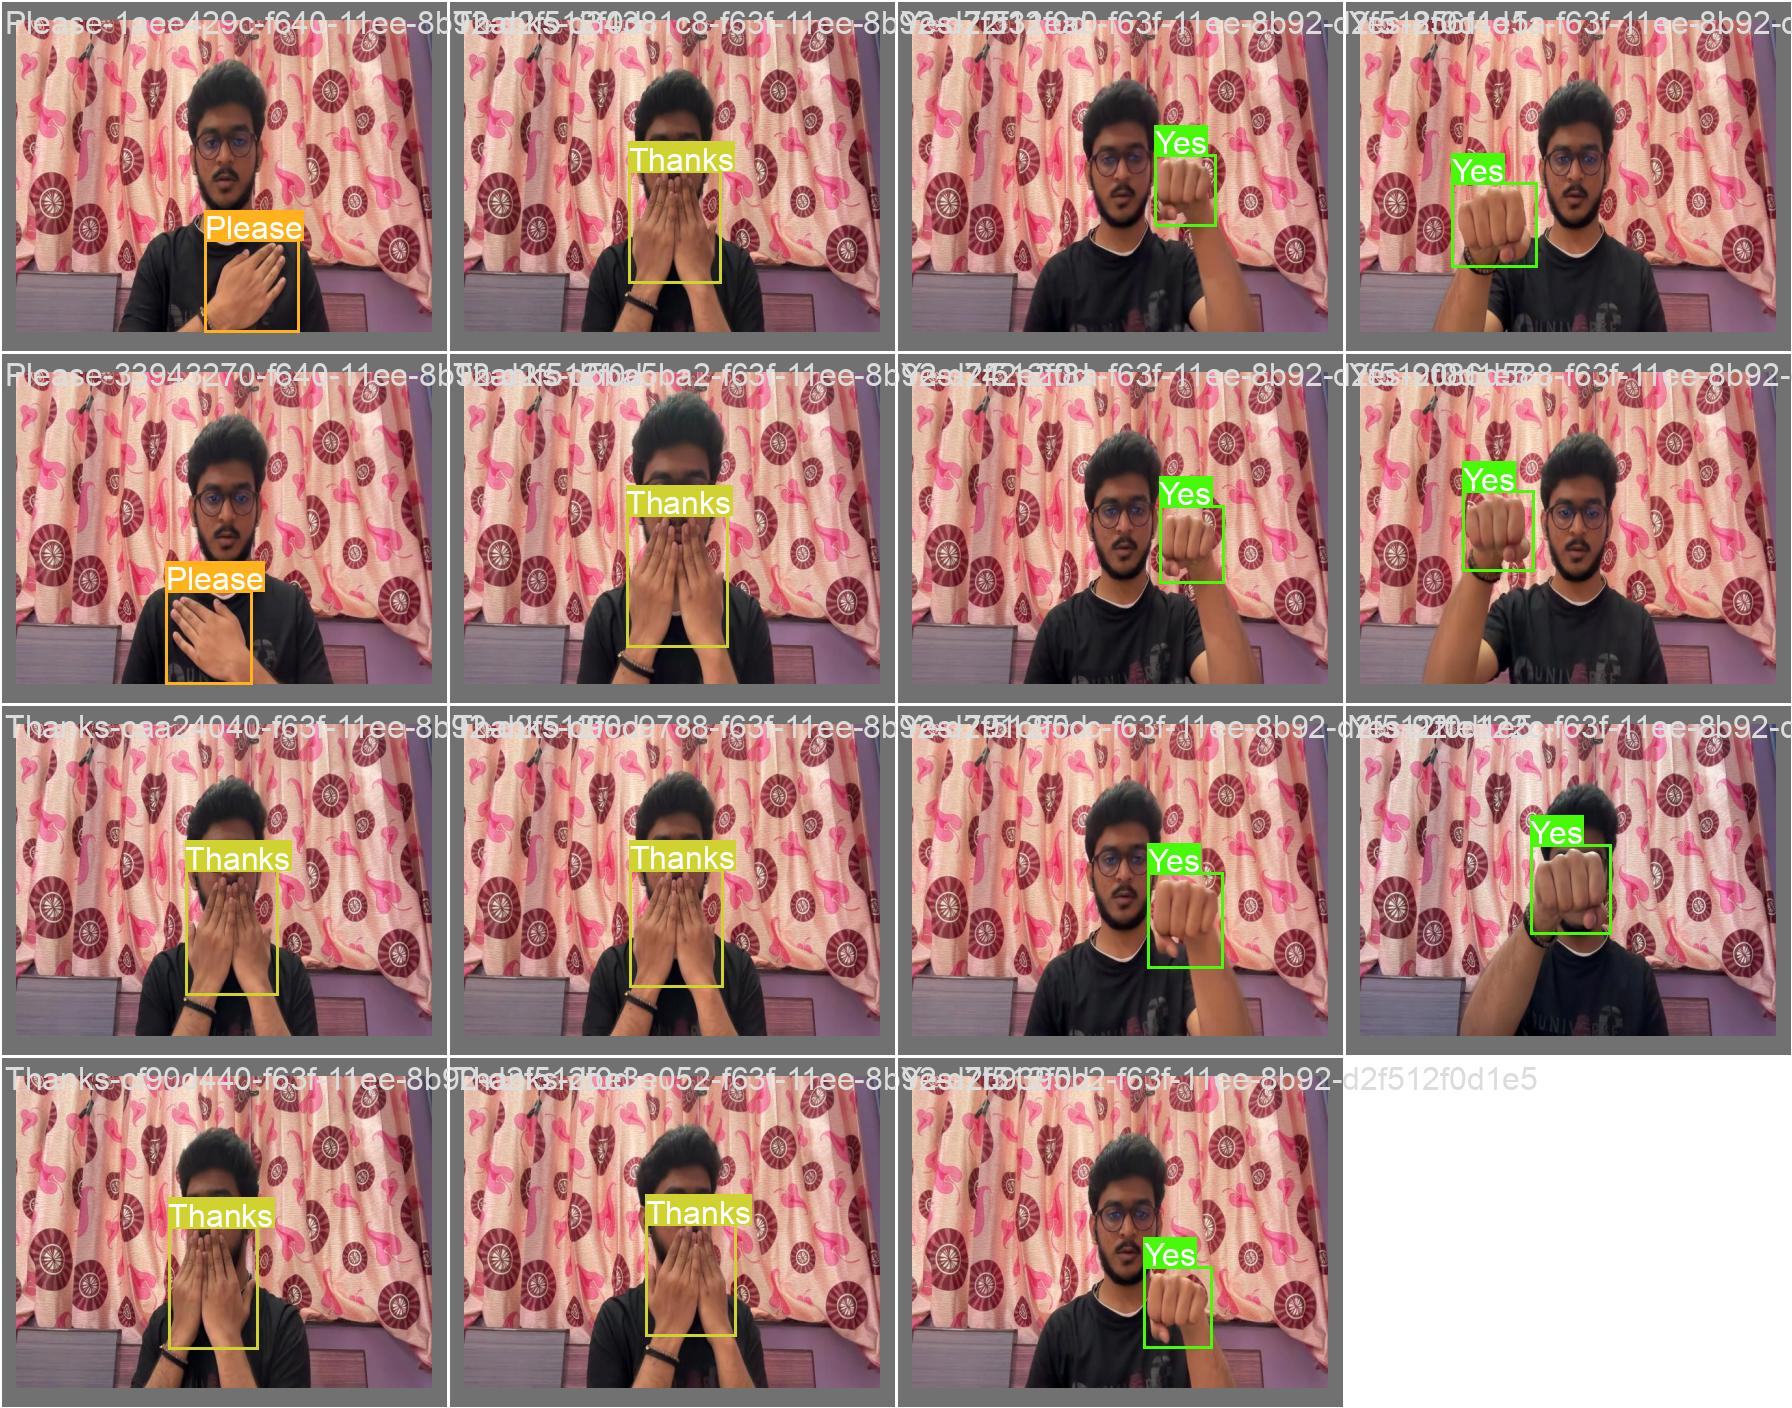

In [22]:
## displaying our gorund truth data
print(f"GROUND TRUTH TRAINING DATA:")
Image(filename="/kaggle/working/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg", width=1000)

GROUND TRUTH AUGMENTED TRAINING DATA:


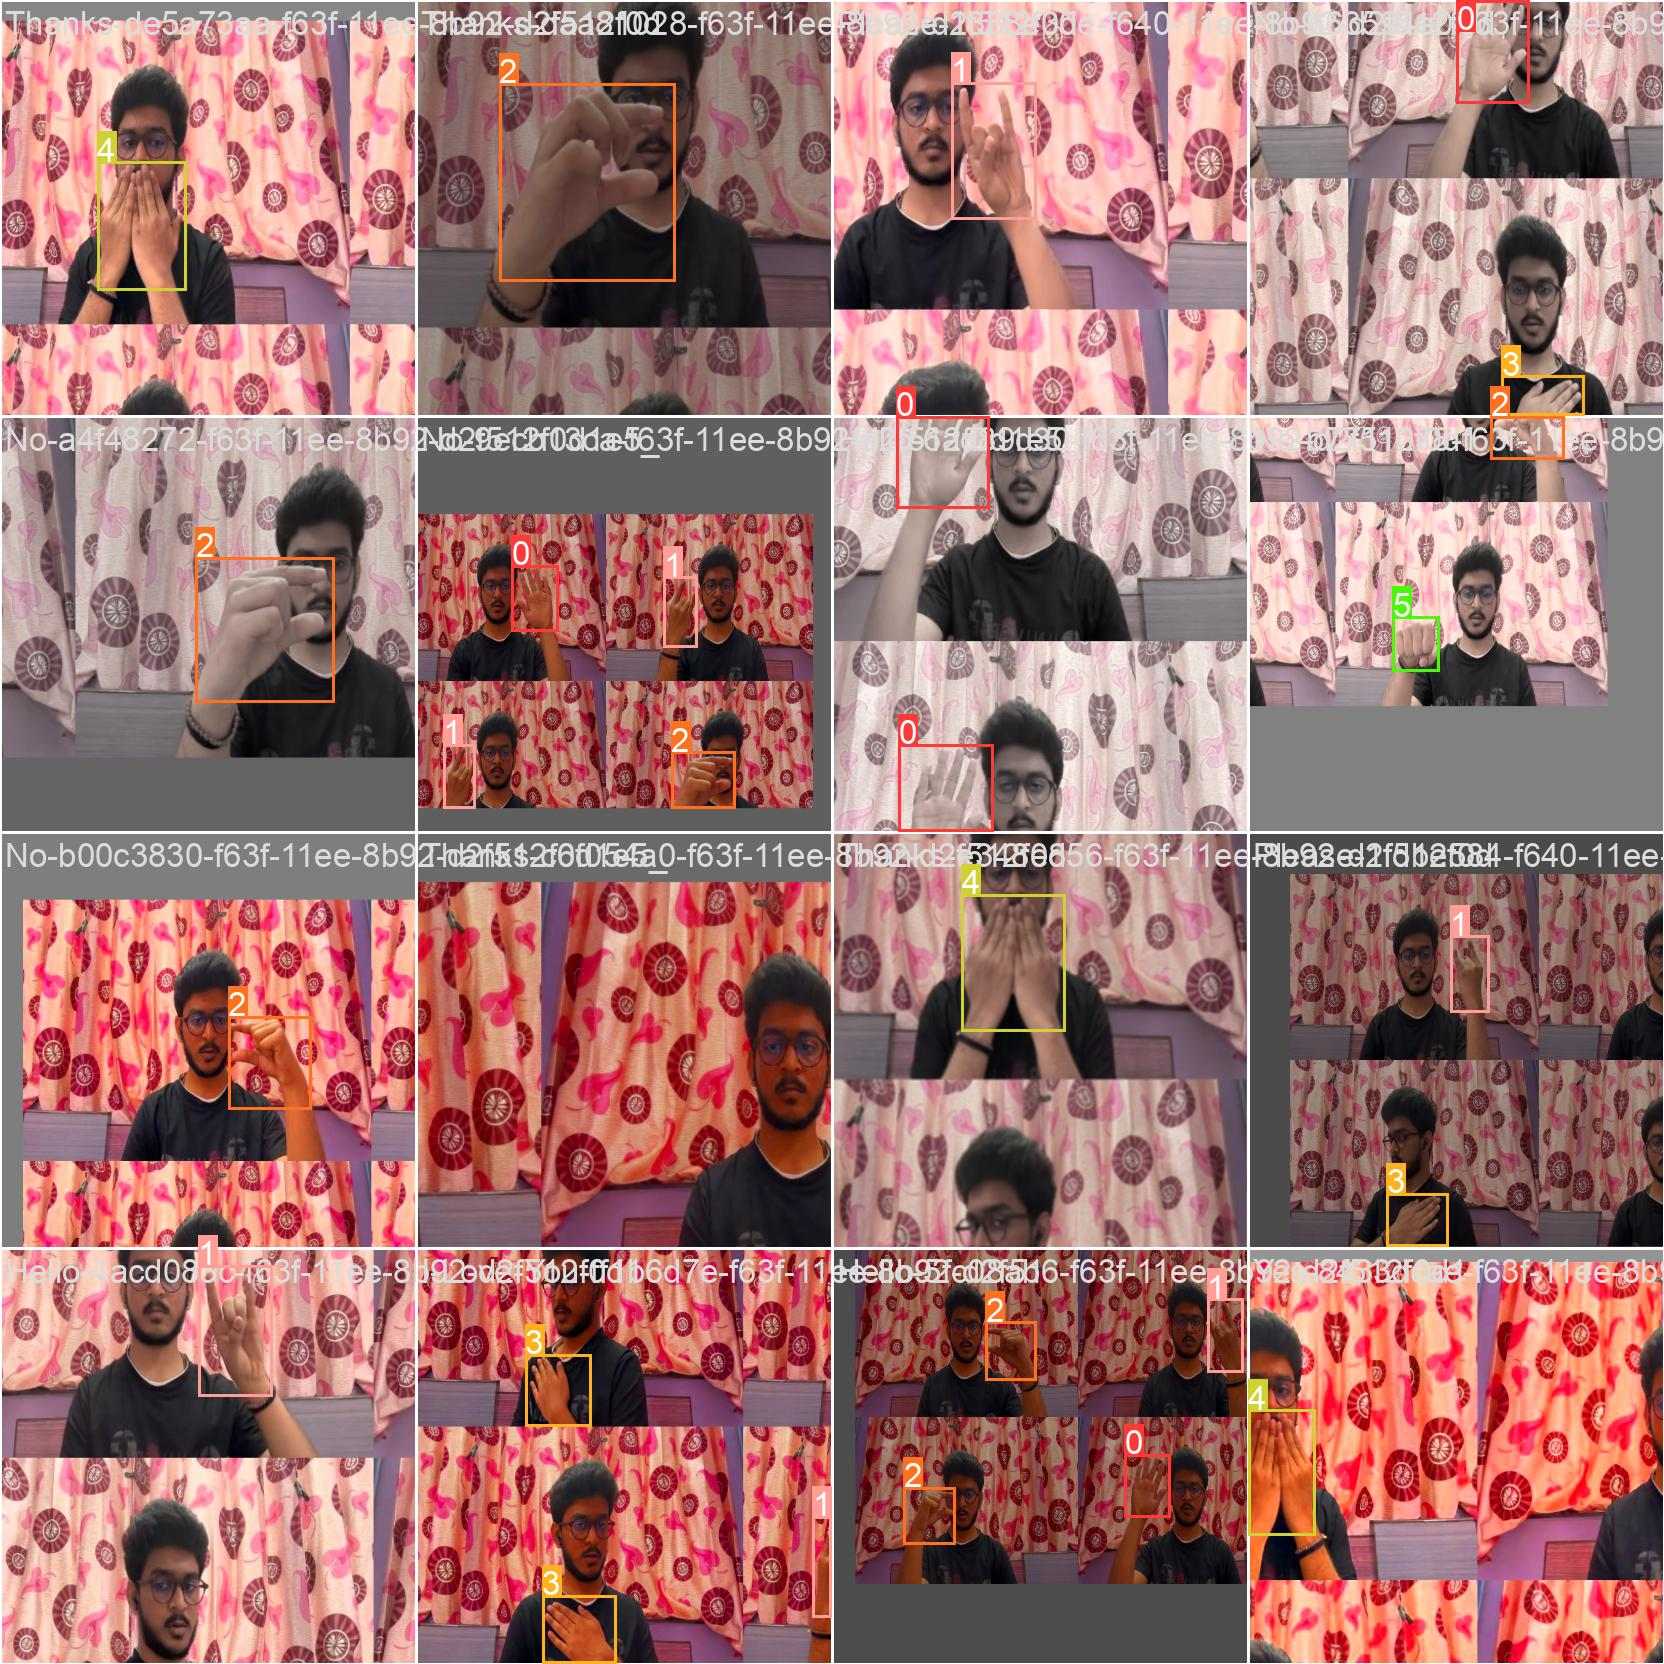

In [23]:
## displaying the augmented image examples
print(f"GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename="/kaggle/working/yolov5/runs/train/yolov5s_results/train_batch0.jpg", width=1000)

Running Inference with Trained Weights

In [24]:
%ls runs

train/


In [25]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [27]:
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.6 --source ../data/sign_language_detection/Sign_Language_Detection.v3i.yolov5pytorch/test/images

detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=../data/sign_language_detection/Sign_Language_Detection.v3i.yolov5pytorch/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-296-gae4ef3b2 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7260003 parameters, 0 gradients
image 1/36 /kaggle/working/data/sign_language_detection/Sign_Language_Detection.v3i.yolov5pytorch/test/images/Hello-4c0859e0-f63f-11ee-8b92-d2f512f0d1e5_jpg.rf.6b6110a61c879aaa29fb71b29c90628a.jpg: 320x416 1 Hello, 49.5ms
image 2/36 /kaggle/working/d

In [29]:
## display inference on all the test images
import glob
from IPython.display import Image, display 

for imageName in glob.glob("/kaggle/working/yolov5/runs/detect/exp*.jpg"):
    display(Image(filename=imageName))
    print("\n")